In [6]:
import astropy as ap
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad as quad
from tqdm import tqdm
import emcee

In [7]:
from astropy.table import Table

# Load the fits file
data = Table.read('StellarMassesGKVv24.fits', format='fits')

filter_data = data[(data['logmstar'] > 9) & (data['Z'] > 5e-3) & (data['Z'] < 0.065)]

ned = filter_data.copy()
ned.sort( 'logmstar' )
print( ned.colnames )
print( ned['uberID Z logmstar'.split()] )

z = filter_data['Z']
logM = filter_data['logmstar']
dlogM = filter_data['dellogmstar']

['uberID', 'Z', 'comovingdist', 'nefffilt', 'snratio', 'ppp', 'nefftemp', 'logmstar', 'dellogmstar', 'mstar', 'delmstar', 'logage', 'dellogage', 'logtau', 'dellogtau', 'logmet', 'dellogmet', 'dustEBV', 'deldustEBV', 'logmremnants', 'dellogmremnants', 'logmintsfh', 'dellogmintsfh', 'logLWage', 'dellogLWage', 'uminusr', 'deluminusr', 'uminusr_stars', 'deluminusr_stars', 'gminusi', 'delgminusi', 'gminusi_stars', 'delgminusi_stars', 'logmoverl_i', 'dellogmoverl_i', 'C_logM_gi', 'C_logM_gistars', 'C_logM_ur', 'C_logM_urstars', 'C_logM_logLWage', 'C_logM_EBV', 'absmag_FUV', 'delabsmag_FUV', 'absmag_NUV', 'delabsmag_NUV', 'absmag_u', 'delabsmag_u', 'absmag_g', 'delabsmag_g', 'absmag_r', 'delabsmag_r', 'absmag_i', 'delabsmag_i', 'absmag_Z', 'delabsmag_Z', 'absmag_Y', 'delabsmag_Y', 'absmag_J', 'delabsmag_J', 'absmag_H', 'delabsmag_H', 'absmag_K', 'delabsmag_K', 'absmag_W1', 'delabsmag_W1', 'absmag_W2', 'delabsmag_W2', 'absmag_FUV_stars', 'delabsmag_FUV_stars', 'absmag_NUV_stars', 'delabsmag_NU

# MCMC

In [3]:
#define all the functions

def schechter_func(ln_mass, phi_star, ln_m_star, alpha):
    x = ln_mass - ln_m_star
    #print(alpha,ln_m_star)
    sch = np.log(10)*phi_star*(10**(x*(alpha+1)))*np.exp(-10**x)
    sch = np.where(np.isfinite(sch), sch, 0)
    return sch

def lnlike(parvals, data, uncerts=None):
    alpha, ln_m_star = parvals
    ln_mass= data 
    
    if ln_m_star < 8 :
        return -np.inf
    
    lnprior = -0.5*( (-1 - alpha)/1.5 )**2.
    # gaussian prior on alpha, centred at -1, with stderr 1.5
    
    phi_star = 32.522501276810594
    # Vectorized calculation of the Schechter function
    sch = schechter_func(ln_mass, phi_star, ln_m_star, alpha)
    
    # Efficient integral computation
    func = lambda x: np.log(10) * phi_star * (10**((x - ln_m_star) * (alpha + 1))) * np.exp(-10**(x - ln_m_star))
    norm, _ = quad(func, a=np.min(ln_mass), b=np.max(ln_mass))
    
    const = 1e-10  # To avoid log(0)
    
    #Vectorized log sum and normalization
#     L = np.nansum(np.log(sch + const)) - len(ln_mass) * np.log(norm + const)

    like = np.clip( sch / norm, 1e-12, np.inf )
    L = np.nansum( np.log( like ) )
    
#     print( alpha, ln_m_star, L)
    return L + lnprior

In [4]:
#define the parameters for emcee

ndim = 2 #m_star,alpha
nwalkers = 30 #>=2*ndim; the more the better but makes the code slow if too many

#define the initial position of the walkers
p0= np.random.rand(nwalkers, ndim) #we use random initial distribution
mstar0 = 9.5 + 0.5 * np.random.randn(nwalkers)
alpha0 = -1.4 + 0.3 * np.random.rand(nwalkers)
p0=np.vstack([alpha0, mstar0]).T

print(p0.shape)
print(p0[0])

(30, 2)
[-1.33535047  9.50999868]


In [5]:
#initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=[logM,dlogM])

In [6]:
#run the sampler
state = sampler.run_mcmc(p0, 100)
sampler.reset()
state = sampler.run_mcmc(state.coords, 100)


emcee: Exception while calling your likelihood function:
  params: [-1.40036656 10.93469299]
  args: [<Column name='logmstar' dtype='float32' unit='dex(Msun)' length=7919>
  9.858135
  9.063624
  9.641511
  9.115373
  9.189837
  9.769682
  9.760006
 10.275988
  9.788141
  9.772195
   9.26261
   9.25223
       ...
  9.667327
 10.147711
 9.6049185
  9.017288
  9.592418
  9.505781
 10.325024
 10.409446
  10.71863
10.3311825
  9.925141
  9.189288, <Column name='dellogmstar' dtype='float32' unit='dex(Msun)' length=7919>
 0.09149935
 0.12209533
0.112708665
 0.13073255
 0.10958288
 0.11234669
 0.11359581
 0.11350184
 0.11537693
 0.12879175
0.102717586
 0.09747942
        ...
 0.12763193
0.057989355
0.057340246
  0.1384526
 0.11539062
 0.13121612
 0.07428396
 0.17782365
 0.10826896
 0.15329854
 0.12661149
 0.08984286]
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "C:\Python311\Lib\site-packages\emcee\ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\catch\AppData\Local\Temp\ipykernel_8524\989000412.py", line 34, in lnlike
    L = np.nansum( np.log( like ) )
                   ^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
walker, step = np.indices( sampler.chain.shape[:2] )

plt.figure()
plt.scatter( sampler.chain[ ..., 0 ], sampler.chain[ ... , 1 ], .5)

plt.figure()
plt.scatter( step, sampler.chain[ ..., 0 ] , 1)

plt.figure()
plt.scatter( step, sampler.chain[ ..., 1 ] ,1)


In [ ]:
x = np.linspace(-1.6,-1,100)
lnlx = lambda x : lnlike( [x,10.85], logM, dlogM )

def lnlx( x ):
    return lnlike( [x,10.85], logM, dlogM )

y = [ lnlx(_x) for _x in x ]
plt.plot(x,y)

## 2 Schechter 5 Parameter MCMC

\begin{equation}
L = \frac{\prod_{m_i} \Phi_{sch}(M_i|\phi^*,M^*,\alpha)}{{\int_{M_{min}}^{M_{max}}}\Phi d(logM)}
\end{equation}

\begin{equation}
\log L = \sum_{m_i} \log \Phi_{sch}(M_i|\phi^*,M^*,\alpha) - N (\log \int_{M_{min}}^{M_{max}}\Phi d(logM))
\end{equation}

\begin{equation}
\Phi_{sch} = f_1 \phi (\alpha_1,M_1^*) + (1-f_1)\phi(\alpha_2,M_2^*)
\end{equation}


\begin{equation}
L = f_1 \frac{\prod \Phi (\log M_i|\phi^*,\alpha_1,M_1^*)}{{\int_{M_{min}}^{M_{max}}}\Phi (\log M_i|\phi^*,\alpha_1,M_1^*) d(logM)} + (1-f_1)\frac{\prod \Phi (\log M_i|\phi^*,\alpha_2,M_2^*)}{{\int_{M_{min}}^{M_{max}}}\Phi (\log M_i|\phi^*,\alpha_2,M_2^*) d(logM)}
\end{equation}

In [7]:
#define all the functions

def schechter_func(ln_mass, phi_star, ln_m_star, alpha):
    x = ln_mass - ln_m_star
    #print(alpha,ln_m_star)
    sch = np.log(10)*phi_star*(10**(x*(alpha+1)))*np.exp(-10**x)
    sch = np.where(np.isfinite(sch), sch, 0)
    return sch
    
def schechter_new(ln_mass, phi_star, ln_m_star1, alpha1, ln_m_star2, alpha2, f1):
    sch1 = f1*schechter_func(ln_mass, phi_star, ln_m_star1, alpha1)
    sch2 = (1-f1)*schechter_func(ln_mass,phi_star, ln_m_star2, alpha2)
    return (sch1+sch2)

def schechter_int(ln_mass, phi_star,ln_m_star, alpha):
    # Efficient integral computation
    func = lambda x: np.log(10) * phi_star * (10**((x - ln_m_star) * (alpha + 1))) * np.exp(-10**(x - ln_m_star))
    norm, _ = quad(func, a=np.min(ln_mass), b=np.max(ln_mass))
    return norm
    
def lnlike(parvals, data, uncerts, return_model=False):
    alpha1, ln_m_star1, alpha2, ln_m_star2, f1= parvals
    ln_mass= data 
    
    a=0
    if ln_m_star1 < 8 or ln_m_star2 < 8 or f1 < 0 or f1 > 1:
        #print( 'badness' )
        a+=1
        return -np.inf
    
    lnprior_alpha1 = -0.5 * ((-1 - alpha1) / 1.5) ** 2
    lnprior_alpha2 = -0.5 * ((-1 - alpha2) / 1.5) ** 2
    # gaussian prior on alpha, centred at -1, with stderr 1.5
    
    lnprior = lnprior_alpha1 + lnprior_alpha2
    
    phi_star = 32.522501276810594
    # Vectorized calculation of the Schechter function
    sch = schechter_new(ln_mass, phi_star, ln_m_star1, alpha1, ln_m_star2, alpha2, f1)
    
    #new integral computation 
    norm = f1*schechter_int(ln_mass, phi_star,ln_m_star1, alpha1) + (1-f1)*schechter_int(ln_mass, phi_star,ln_m_star2, alpha2)
    
    const = 1e-10  # To avoid log(0)
    
    #Vectorized log sum and normalization
#     L = np.nansum(np.log(sch + const)) - len(ln_mass) * np.log(norm + const)

    if return_model :
        return np.clip( sch / norm, 1e-12, np.inf )

    like = np.clip( sch / norm, 1e-12, np.inf )
    L = np.nansum( np.log( like ) )
    
#     print( parvals, L)
    return L + lnprior

In [8]:
#define the parameters for emcee

ndim = 5 #m_star,alpha
nwalkers = 100 #>=2*ndim; the more the better but makes the code slow if too many

#define the initial position of the walkers
p0= np.random.rand(nwalkers, ndim) #we use random initial distribution
mstar00 = 9.7 + 0.005 * np.random.randn(nwalkers)
alpha00 = -1.6 + 0.003 * np.random.rand(nwalkers)
mstar01 = 9.3 + 0.005 * np.random.randn(nwalkers)
alpha01 = -1.6 + 0.003 * np.random.rand(nwalkers)
f1 = np.random.rand(nwalkers)

p0=np.vstack([alpha00, mstar00, alpha01, mstar01, f1]).T

In [9]:
## initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=[logM,dlogM])

In [10]:
#run the sampler
state = sampler.run_mcmc(p0, 1000, progress=True)
#sampler.reset()
#state = sampler.run_mcmc(state.coords, 100, progress=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:31<00:00,  3.02it/s]


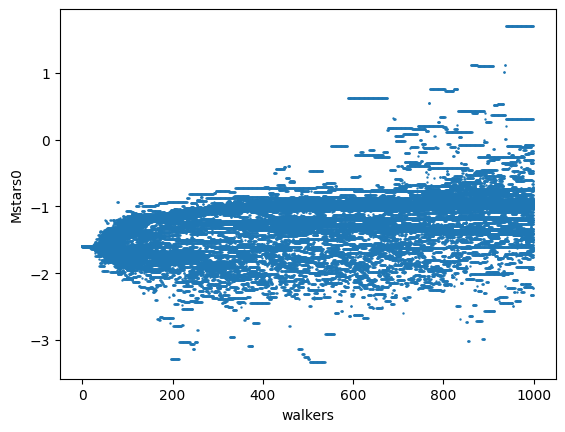

In [11]:
walker, step = np.indices( sampler.chain.shape[:2] )

# plt.figure()
# plt.scatter( sampler.chain[ ..., 0 ], sampler.chain[ ... , 1 ], .5)
# plt.xlabel("alpha0")
# plt.ylabel('Mstar0')
# plt.show()

# plt.figure()
# plt.scatter( step, sampler.chain[ ..., 0 ] , 1)
# plt.xlabel("walkers")
# plt.ylabel('alpha0')
# plt.show()

plt.figure()
plt.scatter( step, sampler.chain[ ..., 2 ] ,0.5)
plt.xlabel("walkers")
plt.ylabel('Mstars0')
plt.show()

#plt.figure()
#plt.scatter( sampler.chain[ ..., 1 ], sampler.chain[ ... , 3 ], .5)
#plt.xlabel("Mstar0")
#plt.ylabel('Mstar1')
#plt.show()

# plt.figure()
# plt.scatter( sampler.chain[ ..., 0 ], sampler.chain[ ... , 2 ], .5)
# plt.xlabel("alpha0")
# plt.ylabel('alpha1')
# #plt.xlim(-1.5,-0.5)
# #plt.ylim(-1.5,-0.5)
# plt.grid()
# plt.show()



In [ ]:
chain = sampler.chain
num_steps, num_walkers, num_params = chain.shape

plt.figure(figsize=(10,10))
for pi in range( num_params ):
    pchain = chain[ ..., pi ]
    plt.subplot( num_params, 1, pi+1 )
    # then plot the trace for this param
    plt.scatter(step, sampler.chain[ ..., pi ] ,0.5)

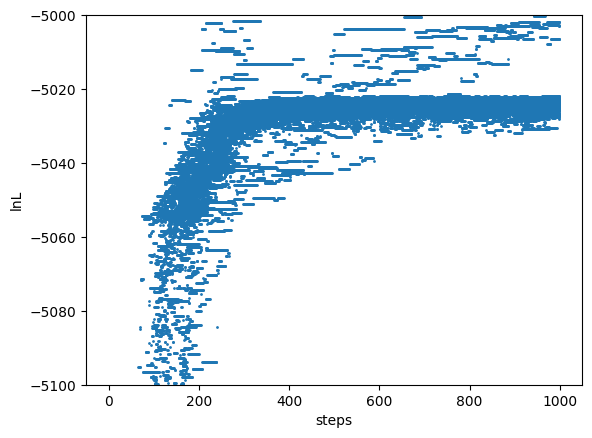

In [13]:
plt.figure()
plt.scatter( step, sampler.lnprobability, 1)
plt.xlabel("steps")
plt.ylabel('lnL')
plt.ylim([-5100,-5000])
plt.show()

In [17]:
print(np.argmax(sampler.lnprobability[:, -1]))

59


(100, 1000, 5)
[-1.5996787   9.70427488 -1.59802992  9.29112116  0.41975914]
[-1.76098841e+00  1.16951622e+01 -8.35938463e-01  1.05802827e+01
  7.52138813e-03]
-19530.803903515778 -5023.208444492158


(0.0001, 1)

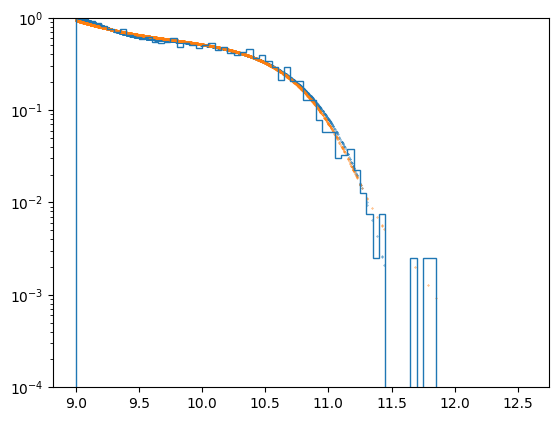

In [25]:
print( sampler.chain.shape )
print( sampler.chain[59,0] )
print( sampler.chain[59,-1] )

args=[logM,dlogM]

first_model = lnlike( sampler.chain[ 0, -1 ], *args, return_model=True )
last_model = lnlike( sampler.chain[ 59, -1 ], *args, return_model=True )

first_lnl = lnlike( sampler.chain[ 0, 0 ], *args )
last_lnl = lnlike( sampler.chain[ 0, -1 ], *args )

print( first_lnl, last_lnl )
plt.clf()
plt.scatter( logM, first_model, .1 )
plt.scatter( logM, last_model, .1 )

plt.hist( logM, bins=np.arange( 9, 12, .05 ), density=True, histtype='step' )



plt.yscale('log')
plt.ylim( 1e-4, 1 )

### emcee fixed

In [1]:
n_iterations = 1000

# First run with tqdm, using the initial positions p0
state = None
for _ in tqdm(range(n_iterations), desc="Running MCMC", unit="steps"):
    state = sampler.run_mcmc(p0, 1)
    p0 = state.coords  # Update p0 to the latest state for the next iteration

sampler.reset()

# Second run with tqdm, continuing from the last coordinates of the first run
for _ in tqdm(range(n_iterations), desc="Continuing MCMC", unit="steps"):
    state = sampler.run_mcmc(state.coords, 1)

NameError: name 'tqdm' is not defined

In [31]:
print(state.coords.shape)

(100, 5)


## 2 Schechter 5 Parameter MCMC with $\phi_0$

\begin{equation}
    N_{exp} = \oint dV \oint_{M_l}^{M_h} \phi d\log M
\end{equation}

\begin{equation}
    L = \frac{1}{\sqrt{2\pi N_{exp}}} exp \left[\frac{-1}{2} \left( \frac{N_{obs} - N_{exp}}{\sqrt{Nexp}}\right)^2\right]
\end{equation}

In [8]:
#define all the functions

def schechter_func(ln_mass, phi_star, ln_m_star, alpha):
    x = ln_mass - ln_m_star
    #print(alpha,ln_m_star)
    sch = np.log(10)*phi_star*(10**(x*(alpha+1)))*np.exp(-10**x)
    sch = np.where(np.isfinite(sch), sch, 0)
    return sch
    
def schechter_new(ln_mass, phi_star, ln_m_star1, alpha1, ln_m_star2, alpha2, f1):
    sch1 = f1*schechter_func(ln_mass, phi_star, ln_m_star1, alpha1)
    sch2 = (1-f1)*schechter_func(ln_mass,phi_star, ln_m_star2, alpha2)
    return (sch1+sch2)

def schechter_int(ln_mass, phi_star,ln_m_star, alpha):
    # Efficient integral computation
    func = lambda x: np.log(10) * phi_star * (10**((x - ln_m_star) * (alpha + 1))) * np.exp(-10**(x - ln_m_star))
    norm, _ = quad(func, a=np.min(ln_mass), b=np.max(ln_mass))
    return norm

In [9]:
def comoving_volume(z_initial, z_final, H0=70, Omega_M=0.3, Omega_Lambda=0.7):
    c = 3e5 #light speed in km/s as H0 is 70km/s/MPc
    # For a flat universe, Omega_k = 0
    Omega_k = 1 - Omega_M - Omega_Lambda  
    # Hubble distance in Mpc
    DH = c / H0  

    # Angular size distance
    def E(z, Omega_M=Omega_M, Omega_Lambda=Omega_Lambda, Omega_k=Omega_k):
        return np.sqrt(Omega_M * (1 + z)**3 + Omega_k * (1 + z)**2 + Omega_Lambda)

    # Integral for comoving distance DC
    def comoving_distance(z):
        return quad(lambda z: 1/E(z), 0, z)[0] * DH

    # Calculate DC for initial and final redshifts
    DC_initial = comoving_distance(z_initial)
    DC_final = comoving_distance(z_final)

    # Volume of the light cone V_C using the formula for Omega_k = 0 (flat universe)
    VC_initial = (4 * np.pi / 3) * DC_initial**3
    VC_final = (4 * np.pi / 3) * DC_final**3

    # The volume covered between z_initial and z_final is the difference
    V_360 = VC_final - VC_initial
    
    #full sky has 41253 sq degrees and GAMA has 250sq degrees
    V_gama = 250/41253 * V_360
    
    return V_gama

# Initial and final redshifts
z_initial = 1e-6
z_final = 0.065

# Calculate and print the volume of the light cone
volume = comoving_volume(z_initial, z_final)
print(f"The volume of the light cone between z={z_initial} and z={z_final} is approximately {volume:.2f} cubic Mpc.")

The volume of the light cone between z=1e-06 and z=0.065 is approximately 524729.98 cubic Mpc.


In [92]:
from astropy.cosmology import Planck15
def co_vol(z_initial, z_final, Omega = 0.0873):
    V23  = Planck15.comoving_volume(z_final) - Planck15.comoving_volume(z_initial)
    V    = Omega/(4*np.pi) * V23
    return V.value

In [93]:
def pslike(ln_mass,phi_star, ln_m_star, alpha):
    #expected Number Counts
    def Nexp(ln_mass, phi_star, ln_m_star, alpha, z_initial=1e-6, z_final=0.065):
        #V=comoving_volume(z_initial,z_final)
        V=co_vol(z_initial,z_final) 
        phi_int =  schechter_int(ln_mass, phi_star, ln_m_star, alpha)
        Nexp = V * phi_int
        print (V)
        return Nexp
    
    #log Likelihood
    Nobs = len(z)
    Nexp = Nexp(ln_mass,phi_star, ln_m_star, alpha)
    logL =(-1./2)*(((Nobs-Nexp)**2)/Nexp) +(1/(2*np.log(2*np.pi*Nexp)))
    print(logL, Nexp, Nobs)
    
    #print(logL, Nobs, Nexp)
    return logL

In [94]:
def lnlike(parvals, data, uncerts):
    alpha, ln_m_star, phi_star = parvals
    ln_mass= data 
    
    if ln_m_star < 8 and phi_star < 0:
        return -np.inf
    
    lnprior = -0.5*( (-2 - alpha)/1.5 )**2.
    # gaussian prior on alpha, centred at -1, with stderr 1.5
    
    # Vectorized calculation of the Schechter function
    sch = schechter_func(ln_mass, phi_star, ln_m_star, alpha)
    
    # Efficient integral computation
    norm = schechter_int(ln_mass, phi_star, ln_m_star, alpha)
    
    const = 1e-10  # To avoid log(0)
    
    #Vectorized log sum and normalization
    #L = np.nansum(np.log(sch + const)) - len(ln_mass) * np.log(norm + const)

    like = np.clip( sch / norm, 1e-12, np.inf )
    L = np.nansum( np.log( like ) )
    
    #print( alpha, ln_m_star, L)
    return L + lnprior #+ pslike(ln_mass, phi_star, ln_m_star, alpha)

In [95]:
lnlike((-1.18,10.85, 32.522501276810594), logM, dlogM)

-5054.920906597222

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1008.29it/s]


661517.6219358544
-82913363.21535142 165842564.10072905 7919
661517.6219358544
-82466375.84185264 164948589.3516946 7919
661517.6219358544
-82022266.57039349 164060370.80673057 7919
661517.6219358544
-81581015.66103761 163177868.9859641 7919
661517.6219358544
-81142603.51518829 162301044.69220176 7919
661517.6219358544
-80707010.67454833 161429859.00884917 7919
661517.6219358544
-80274217.8200871 160564273.29784504 7919
661517.6219358544
-79844205.77101545 159704249.197611 7919
661517.6219358544
-79416955.48376867 158849748.62101766 7919
661517.6219358544
-78992448.05099677 158000733.75336498 7919
661517.6219358544
-78570664.70056206 157157167.0503776 7919
661517.6219358544
-78151586.79454534 156319011.2362171 7919
661517.6219358544
-77735195.82825813 155486229.3015065 7919
661517.6219358544
-77321473.42926349 154658784.50137186 7919
661517.6219358544
-76910401.35640344 153836640.35349724 7919
661517.6219358544
-76501961.4988341 153019760.63619485 7919
661517.6219358544
-76096135.87506

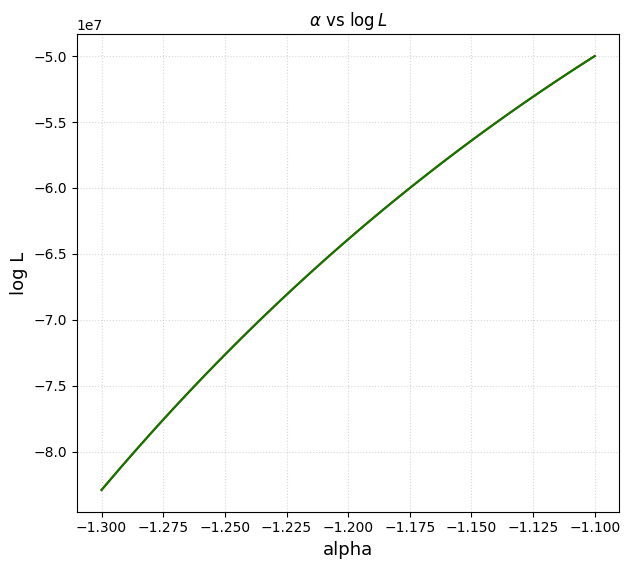

In [96]:
alpha = np.linspace(-1.3,-1.1,100)
L_values = np.zeros(len(alpha))
P_values = np.zeros(len(alpha))
T_values = np.zeros(len(alpha))

from tqdm import tqdm
for i in tqdm(range(len(alpha))):
    phi, M = 32.522501276810594, 86751986104.16612
    L_values[i] = lnlike((alpha[i],10.85, 32.522501276810594), logM, dlogM)
    P_values[i] = pslike(logM, 32.522501276810594, 10.85, alpha[i])
    T_values[i] = L_values[i] + P_values[i]
    
plt.figure(figsize=(7,6.2))

minima = alpha[np.argmax(L_values)]

#plt.plot(alpha,L_values, color= 'blue')
plt.plot(alpha,P_values, color= 'red')
plt.plot(alpha,T_values, color= 'green')

#plt.axvline(x = minima, color = 'black',linestyle=':', label = 'axvline - full height')

#plt.text(minima-0.005, plt.gca().get_ylim()[0]-7, str(round(minima,2)), ha='center', va='top', fontweight=1000)

plt.title(r'$\alpha$ vs $\log L$')

plt.grid(alpha=0.5, linestyle=':')

plt.xlabel('alpha', fontsize=13)
plt.ylabel('log L', fontsize=13)

plt.show()

In [91]:
#define the parameters for emcee

ndim = 5 #m_star,alpha
nwalkers = 100 #>=2*ndim; the more the better but makes the code slow if too many

#define the initial position of the walkers
p0= np.random.rand(nwalkers, ndim) #we use random initial distribution
mstar0 = 9.7 + 0.005 * np.random.randn(nwalkers)
alpha0 = -1.6 + 0.003 * np.random.rand(nwalkers)
f1 = np.random.rand(nwalkers)

p0=np.vstack([alpha00, mstar00, alpha01, mstar01, f1]).T

NameError: name 'alpha00' is not defined